In [2]:
#import packages
import numpy as np # linear algebra
import pandas as pd # data processing
import torch 
import torch.nn as nn
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
import seaborn as sns

#load and print data
data = pd.read_csv('/content/SynchronousMachine.csv')
data['id'] = data.index
print(data.head())

   I_y    PF  e_PF   d_if    I_f  id
0  3.0  0.66  0.34  0.383  1.563   0
1  3.0  0.68  0.32  0.372  1.552   1
2  3.0  0.70  0.30  0.360  1.540   2
3  3.0  0.72  0.28  0.338  1.518   3
4  3.0  0.74  0.26  0.317  1.497   4


In [ ]:
data.describe()

,I_y,PF,e_PF,d_if,I_f,id
count,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000
mean,4.499820,0.825296,0.174704,0.350659,1.530659,278.000000
std,0.896024,0.103925,0.103925,0.180566,0.180566,160.936323
min,3.000000,0.650000,0.000000,0.037000,1.217000,0.000000
25%,3.700000,0.740000,0.080000,0.189000,1.369000,139.000000
50%,4.500000,0.820000,0.180000,0.345000,1.525000,278.000000
75%,5.300000,0.920000,0.260000,0.486000,1.666000,417.000000
max,6.000000,1.000000,0.350000,0.769000,1.949000,556.000000


<AxesSubplot:title={'center':'Plot of power factor and excitation current of synchronous machine'}>

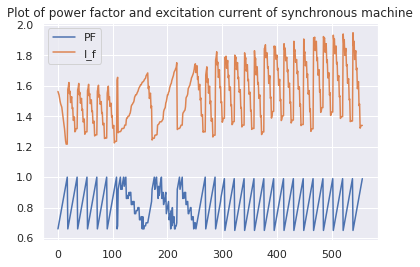

In [ ]:
%matplotlib inline
sns.set()
data.plot(y=['PF', 'I_f'], title='Plot of power factor and excitation current of synchronous machine')

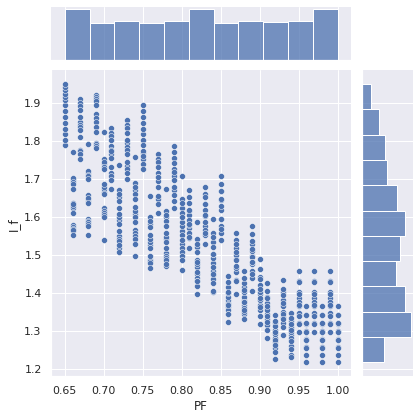

In [ ]:
sns.jointplot(data=data,x='PF', y='I_f')

In [16]:
from sklearn.model_selection import train_test_split
#target value is excitation current of synchronous machine I_f
y = data['I_f']
X = data.drop(['I_f'], axis=1)
        
X = torch.from_numpy(X.values).float() 
y = torch.from_numpy(y.values).float()

rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

In [14]:
#normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_dataset.reshape(-1, 1))

AttributeError: ignored

In [9]:
#Bidirectional LSTM class
class NET(nn.Module):
    def __init__(self, in_size, h_size, n_layers, out_size):
        super(NET, self).__init__()
        self.h_size = h_size
        self.n_layers = n_layers
        self.out_size = out_size
        self.lstm = nn.LSTM(in_size, h_size, n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(h_size * 2, out_size)
             
    def forward(self, x):
        #init. states 
        h0 = torch.zeros(self.n_layers * 2, x.size(0), self.h_size)
        c0 = torch.zeros(self.n_layers * 2, x.size(0), self.h_size)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out)
        return out 

In [10]:
#defining the sequence length and the sessions ids which are used for training
seq_len = 100
ids = [4, 6, 10, 11, 20, 27, 29, 30, 31,32, 36] + [i+41 for i in range(35)]

#create an lstm instance
model = NET(11, 20, 2, 1)
print(model)

#define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

NET(
  (lstm): LSTM(11, 20, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)


In [11]:
n_epochs = 30

#train model
train_losses = []

model.train()
for e in range(n_epochs):
        optimizer.zero_grad()
        out = model.forward(X.view(-1, seq_len, 11))
        loss = criterion(out, y.view(-1, seq_len, 1))
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    
#print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()

RuntimeError: ignored